# Basic Decline Curve Analysis

This notebook demonstrates the fundamentals of decline curve analysis using Arps models.

## What You'll Learn
- Load and visualize production data
- Fit Arps decline models (exponential, harmonic, hyperbolic)
- Generate production forecasts
- Evaluate model performance
- Create professional visualizations

In [1]:
%pip install -e "..[examples]"

# Import required libraries
import sys
sys.path.insert(0, '..')
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decline_curve import dca
from decline_curve.logging_config import configure_logging, get_logger

# Configure logging
configure_logging(level=logging.INFO)
logger = get_logger(__name__)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Obtaining file:///C:/Users/wjdol/Venv/OGDecline/pydca
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for decline-curve (pyproject.toml): started
  Building editable for decline-curve (pyproject.toml): finished with status 'done'
  Created wheel for decline-curve: filename=decline_curve-0.2.1-0.editable-py3-none-any.whl size=6268 sha256=0180e13b8dd8f9354a5c8b2fee53b03edaf4fa69cdb114ad645fb147992b60f6
  Stored in directory: C:\Users\wjdol\AppData\Local\Temp\pip-ephem-wheel-cache-iiqk3gu8\wheels\89\2a\8c\7d6d7a49fd59cd1879f37942

## 1. Load Production Data

We'll start by loading sample production data from a single well.

In [2]:
# Load sample well data
df = pd.read_csv('data/sample_well_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Display first few rows
logger.info("Production Data Summary")
logger.info(f"Period: {df.index[0].strftime('%Y-%m')} to {df.index[-1].strftime('%Y-%m')}")
logger.info(f"Data points: {len(df)}")
logger.info(f"Peak production: {df['oil_bbl'].max():.0f} bbl/month")
logger.info(f"Current production: {df['oil_bbl'].iloc[-1]:.0f} bbl/month")
logger.info(f"Cumulative production: {df['oil_bbl'].sum():.0f} bbl")

df.head()

2026-02-06 19:32:40,523 - __main__ - INFO - Production Data Summary
2026-02-06 19:32:40,524 - __main__ - INFO - Period: 2022-01 to 2024-12
2026-02-06 19:32:40,524 - __main__ - INFO - Data points: 36
2026-02-06 19:32:40,525 - __main__ - INFO - Peak production: 1200 bbl/month
2026-02-06 19:32:40,526 - __main__ - INFO - Current production: 353 bbl/month
2026-02-06 19:32:40,527 - __main__ - INFO - Cumulative production: 23193 bbl


,oil_bbl
date,
2022-01-01,1200
2022-02-01,1140
2022-03-01,1085
2022-04-01,1035
2022-05-01,988


## 2. Visualize Historical Production

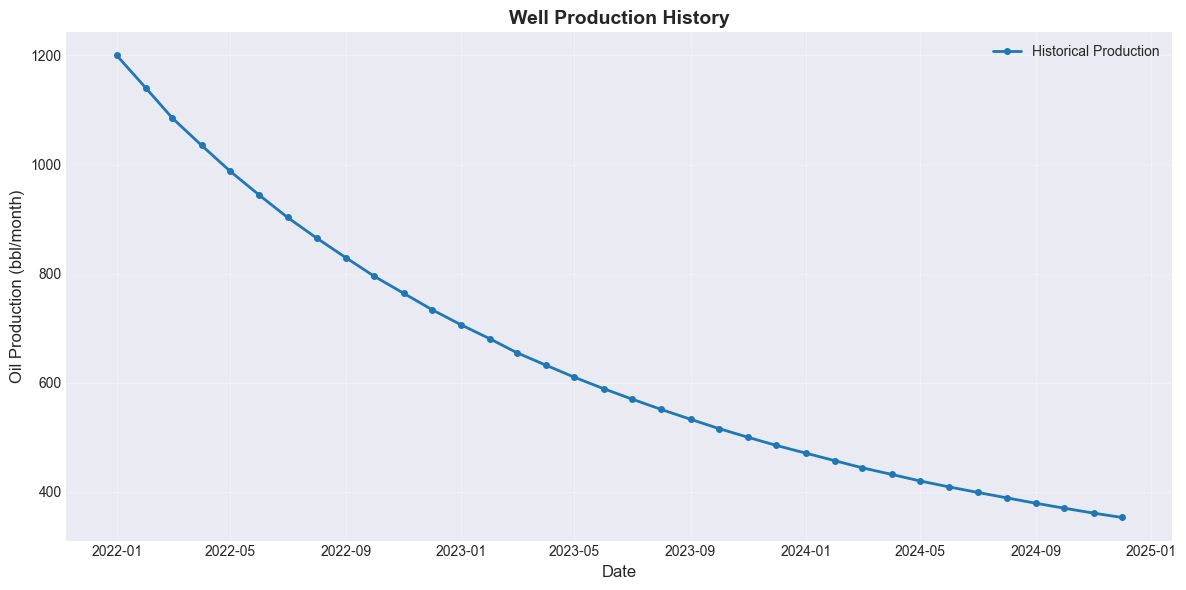

In [3]:
# Plot production history
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['oil_bbl'], 'o-', linewidth=2, markersize=4, label='Historical Production')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Oil Production (bbl/month)', fontsize=12)
ax.set_title('Well Production History', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Fit Arps Decline Models

We'll compare three types of Arps decline models:
- **Exponential**: Constant decline rate (b=0)
- **Harmonic**: Decline rate decreases linearly (b=1)
- **Hyperbolic**: Decline rate decreases with exponent b (0<b<1)

In [4]:
# Create series for forecasting
series = df['oil_bbl']

# Forecast with different Arps models
models = {
    'Exponential': 'exponential',
    'Harmonic': 'harmonic',
    'Hyperbolic': 'hyperbolic'
}

forecasts = {}
metrics = {}

for name, kind in models.items():
    # Generate 12-month forecast
    forecast = dca.forecast(series, model='arps', kind=kind, horizon=12)
    forecasts[name] = forecast
    
    # Evaluate on historical data
    metric = dca.evaluate(series, forecast)
    metrics[name] = metric
    
    logger.info(f"{name} Model:")
    logger.info(f"  RMSE: {metric['rmse']:.2f} bbl/month")
    logger.info(f"  MAE: {metric['mae']:.2f} bbl/month")
    logger.info(f"  SMAPE: {metric['smape']:.2f}%")

2026-02-06 19:32:59,633 - __main__ - INFO - Exponential Model:
2026-02-06 19:32:59,634 - __main__ - INFO -   RMSE: 23.26 bbl/month
2026-02-06 19:32:59,635 - __main__ - INFO -   MAE: 19.91 bbl/month
2026-02-06 19:32:59,636 - __main__ - INFO -   SMAPE: 3.57%
2026-02-06 19:32:59,642 - __main__ - INFO - Harmonic Model:
2026-02-06 19:32:59,643 - __main__ - INFO -   RMSE: 14.96 bbl/month
2026-02-06 19:32:59,644 - __main__ - INFO -   MAE: 13.17 bbl/month
2026-02-06 19:32:59,645 - __main__ - INFO -   SMAPE: 2.30%
2026-02-06 19:32:59,812 - __main__ - INFO - Hyperbolic Model:
2026-02-06 19:32:59,812 - __main__ - INFO -   RMSE: 1.19 bbl/month
2026-02-06 19:32:59,812 - __main__ - INFO -   MAE: 1.04 bbl/month
2026-02-06 19:32:59,814 - __main__ - INFO -   SMAPE: 0.20%


## 4. Compare Model Forecasts

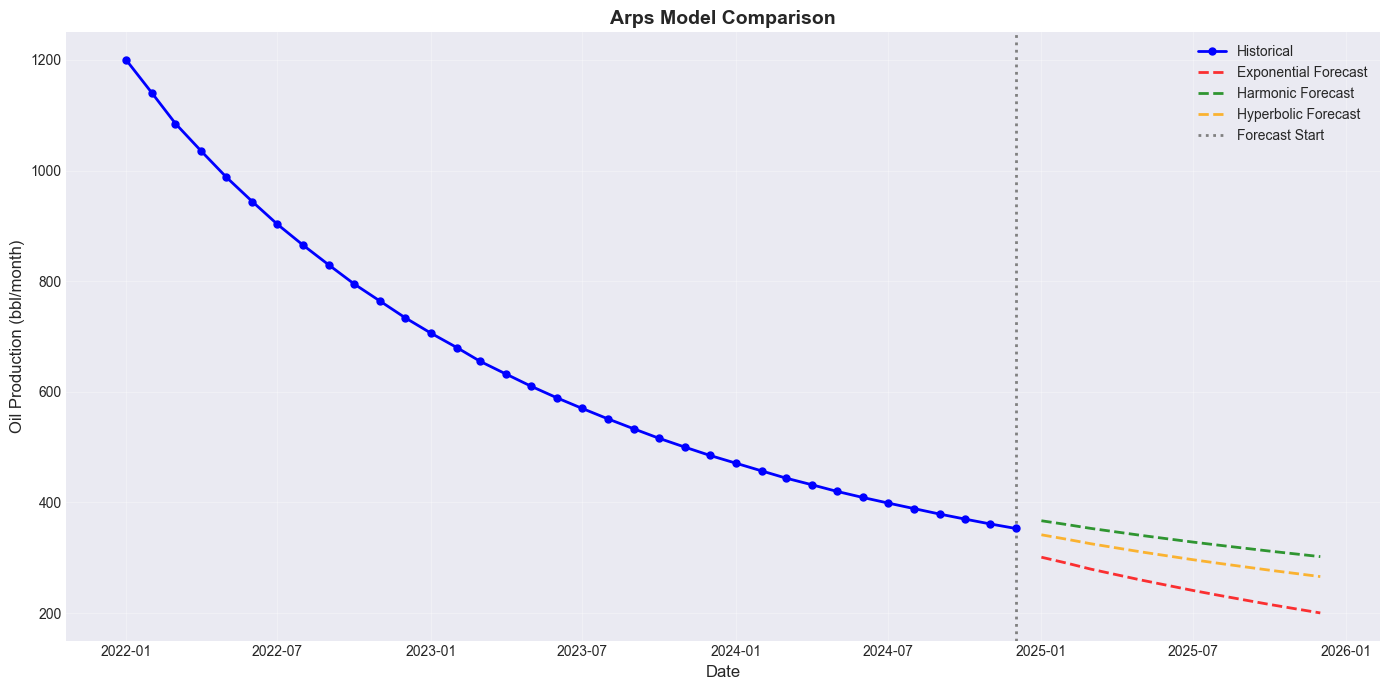

In [5]:
# Plot all forecasts together
fig, ax = plt.subplots(figsize=(14, 7))

# Plot historical data
ax.plot(series.index, series.values, 'o-', 
        color='blue', linewidth=2, markersize=5, label='Historical', zorder=5)

# Plot forecasts
colors = ['red', 'green', 'orange']
for (name, forecast), color in zip(forecasts.items(), colors):
    # Extract forecast portion only
    forecast_part = forecast.iloc[len(series):]
    ax.plot(forecast_part.index, forecast_part.values, '--', 
            color=color, linewidth=2, label=f'{name} Forecast', alpha=0.8)

# Add vertical line at forecast start
ax.axvline(x=series.index[-1], color='gray', linestyle=':', linewidth=2, label='Forecast Start')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Oil Production (bbl/month)', fontsize=12)
ax.set_title('Arps Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Model Performance Comparison

In [6]:
# Create metrics comparison DataFrame
metrics_df = pd.DataFrame(metrics).T
logger.info("Model Performance Metrics:")
logger.info(metrics_df.round(2))

# Find best model
best_model = metrics_df['rmse'].idxmin()
logger.info(f"✓ Best performing model: {best_model} (lowest RMSE)")

2026-02-06 19:33:22,964 - __main__ - INFO - Model Performance Metrics:
2026-02-06 19:33:22,965 - __main__ - INFO -               rmse    mae  smape
Exponential  23.26  19.91   3.57
Harmonic     14.96  13.17   2.30
Hyperbolic    1.19   1.04   0.20
2026-02-06 19:33:22,968 - __main__ - INFO - ✓ Best performing model: Hyperbolic (lowest RMSE)


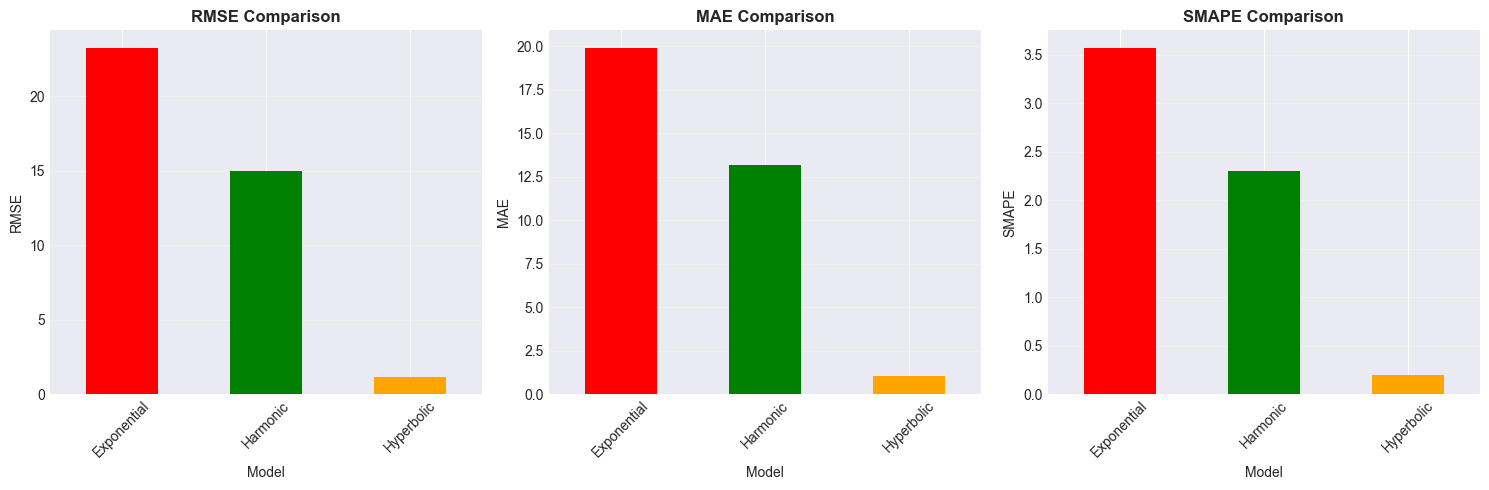

In [7]:
# Visualize metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(['rmse', 'mae', 'smape']):
    metrics_df[metric].plot(kind='bar', ax=axes[idx], color=['red', 'green', 'orange'])
    axes[idx].set_title(f'{metric.upper()} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].set_xlabel('Model')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Generate Final Forecast with Best Model

In [8]:
# Use best model for final forecast
best_kind = models[best_model]
final_forecast = dca.forecast(series, model='arps', kind=best_kind, horizon=24)

logger.info(f"Final Forecast using {best_model} Model:")
logger.info(f"Forecast for next 6 months:")
forecast_only = final_forecast.iloc[len(series):len(series)+6]
for date, value in forecast_only.items():
    logger.info(f"  {date.strftime('%Y-%m')}: {value:.0f} bbl/month")

# Calculate decline rate
current_rate = series.iloc[-1]
forecast_6m = forecast_only.iloc[5]
decline_pct = ((current_rate - forecast_6m) / current_rate) * 100
logger.info(f"Expected 6-month decline: {decline_pct:.1f}%")

2026-02-06 19:34:09,976 - __main__ - INFO - Final Forecast using Hyperbolic Model:
2026-02-06 19:34:09,977 - __main__ - INFO - Forecast for next 6 months:
2026-02-06 19:34:09,981 - __main__ - INFO -   2025-01: 341 bbl/month
2026-02-06 19:34:09,982 - __main__ - INFO -   2025-02: 333 bbl/month
2026-02-06 19:34:09,983 - __main__ - INFO -   2025-03: 325 bbl/month
2026-02-06 19:34:09,984 - __main__ - INFO -   2025-04: 318 bbl/month
2026-02-06 19:34:09,985 - __main__ - INFO -   2025-05: 310 bbl/month
2026-02-06 19:34:09,986 - __main__ - INFO -   2025-06: 303 bbl/month
2026-02-06 19:34:09,987 - __main__ - INFO - Expected 6-month decline: 14.1%


## 7. Professional Visualization

2026-02-06 19:34:20,224 - decline_curve.plot - INFO - Plot saved to production_forecast.png


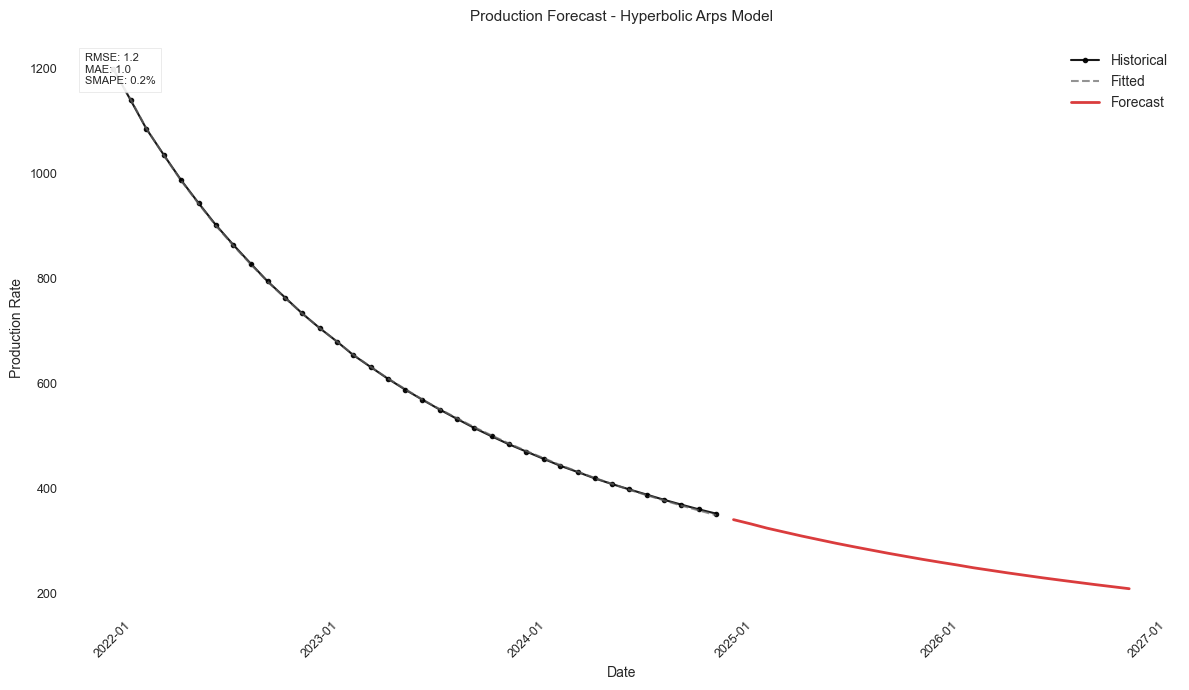

2026-02-06 19:34:20,302 - __main__ - INFO - Plot saved as 'production_forecast.png'


In [9]:
# Create publication-ready plot
dca.plot(series, final_forecast, 
         title=f'Production Forecast - {best_model} Arps Model',
         filename='production_forecast.png')

logger.info("Plot saved as 'production_forecast.png'")

## Summary

In this notebook, we:
1. Loaded and visualized production data
2. Fitted three types of Arps decline models
3. Generated and compared forecasts
4. Evaluated model performance
5. Selected the best model based on metrics
6. Created professional visualizations

## Next Steps

- **Notebook 02**: Learn economic evaluation and reserves estimation
- **Notebook 03**: Analyze multiple wells simultaneously
- **Notebook 04**: Explore advanced ML forecasting models